### Imports

In [1]:
# Import libraries needed for webscraping
import requests
from datetime import datetime
import time
import random
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import regex as re
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize, RegexpTokenizer

from bs4 import BeautifulSoup    

import unidecode
import contractions
import redditcleaner
import spacy
#spacy.cli.download('en_core_web_md')
#spacy.cli.download('en_core_web_sm')

pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

In [2]:
#!pip install contractions

In [3]:
#pip install redditcleaner

### Load Data

In [4]:
awardtravel = pd.read_csv('../data/awardtravel_4000.csv')
travelhacks = pd.read_csv('../data/TravelHacks_4000.csv')

### Basic data cleaning

#### Check for removed, deleted, NaN posts
    Instead of dropping those value, I replaced them with empty string because the titles still capatured the information about the posts.  

In [5]:
travelhacks.head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
0,TravelHacks,Has anyone booked a flight to Costa Rica witho...,Winging Costa rica,NaN,lucylovesugly1,NaN,0,4/2/2023 6:51
1,TravelHacks,"Hey, me and my friend are planning to go on a ...","I'm planning a backpacking trip to Romania, an...",NaN,wbtr42,NaN,0,4/2/2023 6:37
2,TravelHacks,Hey all. Planning on a visit to Chile and Arge...,Are there any budget friendly ways to get a ta...,NaN,bak1n,NaN,0,4/2/2023 6:10
3,TravelHacks,[removed],Niagara Falls NY,NaN,Proud-Assumption-353,moderator,0,4/2/2023 5:28
4,TravelHacks,I’m heading to Europe for work in June and wan...,Nice &gt; Rome flights/airlines,NaN,efisk1990,NaN,0,4/2/2023 5:06


In [6]:
# check null value: no null value for title but 516 null calue for selftext
travelhacks.isna().sum()

subreddit                 0
selftext                506
title                     0
distinguished          3855
author                    0
removed_by_category    2187
num_comments              0
utc_datetime_str          0
dtype: int64

In [7]:
# even it showed nan for selftext, title still have content
travelhacks[travelhacks['selftext'].isnull()].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
36,TravelHacks,NaN,Easiest ways to keep US mobile phone number wh...,NaN,the-cathedral-,NaN,0,4/1/2023 4:41
43,TravelHacks,NaN,Hello,NaN,selepsoron6389,moderator,0,3/31/2023 22:57
69,TravelHacks,NaN,httpsairlinesboardingpass onlineairlines check...,NaN,changeflightbooking,reddit,0,3/31/2023 14:54
77,TravelHacks,NaN,Cruise question - choosing a cabin? Traveling ...,NaN,aimhighsb,moderator,0,3/31/2023 14:15
81,TravelHacks,NaN,All-Sponsored Happiness Program in Finland - L...,NaN,MadsyKa,moderator,0,3/31/2023 12:34


In [8]:
# replace Nan with empty string
travelhacks['selftext'] = travelhacks['selftext'].fillna('')

In [9]:
# checking for both removed or deleted posts
travelhacks.loc[travelhacks['selftext'].str.contains(r'\[removed\]|\[deleted\]')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
3,TravelHacks,[removed],Niagara Falls NY,NaN,Proud-Assumption-353,moderator,0,4/2/2023 5:28
5,TravelHacks,[removed],Most beautiful places to visit in France other...,NaN,exploreofficial,moderator,0,4/2/2023 4:05
6,TravelHacks,[removed],MOST BEAUTIFUL PLACES TO VISIT IN FRANCE OTHER...,NaN,exploreofficial,moderator,0,4/2/2023 3:32
9,TravelHacks,[removed],Am available for hook up,NaN,lovrencate,moderator,0,4/2/2023 0:23
12,TravelHacks,[removed],Prezi /Onenote / Canva,NaN,No-Potential-6148,moderator,0,4/1/2023 22:18


In [10]:
# replace 'remove' and 'deleted' since the title still have information about the post
travelhacks['selftext'] = travelhacks['selftext'].replace('[removed]', '')
travelhacks['selftext'] = travelhacks['selftext'].replace('[deleted]', '')

In [11]:
awardtravel.head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
0,awardtravel,Got about 400k MR. Would like business for 2 t...,Sfo to hkg january time frame,NaN,NorcalGamers627,NaN,1,4/2/2023 4:55
1,awardtravel,Hey - we have about \~200K AmEx points saved u...,Best way to fly to Japan in business or 1st cl...,NaN,altoid_trapezoid,NaN,1,4/2/2023 3:43
2,awardtravel,"Finally!! Got the booking confirmed for two ,\...",booked JAL F for two via Cathay!!! But now adv...,NaN,Leezy36,NaN,1,4/2/2023 3:07
3,awardtravel,Hoping to plan a Japan ski trip for Jan/Feb 20...,ANA Stopover Question,NaN,SnooDoughnuts785,NaN,1,4/2/2023 1:25
4,awardtravel,I booked an EgyptAir flight that connects in C...,Is it possible to ask for a longer layover on ...,NaN,ReasonWithMe007,NaN,1,4/2/2023 0:43


In [12]:
awardtravel.isna().sum()

subreddit                 0
selftext                 88
title                     0
distinguished          3948
author                    0
removed_by_category    3474
num_comments              0
utc_datetime_str          0
dtype: int64

In [13]:
# even it showed nan for selftext, title still have content
awardtravel[awardtravel['selftext'].isnull()].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
13,awardtravel,NaN,"i fly a lot, so my friends came to me to use m...",NaN,professional_pupper,NaN,1,4/1/2023 17:11
36,awardtravel,NaN,Can't search on AF/KLM,NaN,ebpomtl,NaN,1,3/31/2023 12:11
83,awardtravel,NaN,"Quickest way to offload my remaining 80,000 Wo...",NaN,vialpandomc,NaN,1,3/29/2023 19:08
88,awardtravel,NaN,Global Entry/Trusted Traveler Appointment Finder,NaN,toastingdetermined,moderator,1,3/29/2023 16:31
105,awardtravel,NaN,question if I book award flight in economy on ...,NaN,Mysterious_Pie_4594,NaN,1,3/28/2023 19:27


In [14]:
# replace Nan with empty string
awardtravel['selftext'] = awardtravel['selftext'].fillna('')

In [15]:
# checking for both removed or deleted posts
awardtravel.loc[awardtravel['selftext'].str.contains(r'\[removed\]|\[deleted\]')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
31,awardtravel,[removed],Marriott and United - Comparing Miles earned p...,NaN,Tejavepa,reddit,0,3/31/2023 16:42
82,awardtravel,[removed],First time booking with chase (or any credit c...,NaN,eroxal,moderator,1,3/29/2023 19:16
84,awardtravel,[removed],When the Chase portal hotels are way overprice...,NaN,airplanedad,moderator,1,3/29/2023 18:03
94,awardtravel,[removed],Horton Studios,NaN,zhinocoaster,reddit,1,3/29/2023 13:16
119,awardtravel,[removed],Cabo Award Flights,NaN,Lil_Mikee,moderator,0,3/28/2023 6:41


In [16]:
# replace 'remove' and 'deleted' since the title still have information about the post
awardtravel['selftext'] = awardtravel['selftext'].replace('[removed]', '')
awardtravel['selftext'] = awardtravel['selftext'].replace('[deleted]', '')

#### Check for weekly mod posts from the moderators of the subreddit: 
    Some subreddits would post weekly announcements, daily surveys, or recommendations. Since these posts were posted on the weekly/daily bases with similar titles or contents, it's best to remove these posts to avoid skewness of some words. After checking, both subreddits do not have such issue.

In [17]:
travelhacks['author'].value_counts()

TMavrat                 53
zimmermanus             38
[deleted]               29
John_Martson_isalive    24
jameswood111            21
                        ..
doorhinge3987            1
Icantthinkofone14        1
Visible_Outside5322      1
Lialia0424               1
fujixgrafy               1
Name: author, Length: 3075, dtype: int64

In [18]:
# looks like TMavrat is the moderator and all posts were poll; will drop the posts from him
travelhacks.loc[travelhacks['author'].str.contains(r'TMavrat')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
26,TravelHacks,\n\n[View Poll](https://www.reddit.com/poll/12...,Which would you prefer to visit on a euro trip?,NaN,TMavrat,NaN,0,4/1/2023 15:32
198,TravelHacks,\n\n[View Poll](https://www.reddit.com/poll/12...,Where do you carry your laptop charger?,NaN,TMavrat,NaN,0,3/29/2023 3:15
270,TravelHacks,\n\n[View Poll](https://www.reddit.com/poll/12...,Which airline do you prefer ?,NaN,TMavrat,NaN,0,3/28/2023 2:18
407,TravelHacks,\n\n[View Poll](https://www.reddit.com/poll/12...,Which of these Swiss cities is best to base in...,NaN,TMavrat,NaN,0,3/25/2023 1:39
408,TravelHacks,\n\n[View Poll](https://www.reddit.com/poll/12...,Which of these Swiss cities is best to base in...,NaN,TMavrat,NaN,0,3/25/2023 1:38


In [19]:
# posts from zimmermanus are not mod posts; will keep them
travelhacks.loc[travelhacks['author'].str.contains(r'zimmermanus')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
309,TravelHacks,,"Travel to Luon cave, Halong bay Vietnam, from ...",NaN,zimmermanus,reddit,0,3/27/2023 8:23
361,TravelHacks,,EXCELTREND SUMMER OUTING AT HIDDEN VALLEY PINA...,NaN,zimmermanus,reddit,0,3/26/2023 6:29
441,TravelHacks,,Halong Bay Vietnam Capella cruise cooking clas...,NaN,zimmermanus,reddit,0,3/24/2023 5:25
481,TravelHacks,,Tour Halong Bay Vietnam Capella cruise ship. Y...,NaN,zimmermanus,reddit,0,3/23/2023 3:17
628,TravelHacks,,Fly to and luxury Capella Cruise Halong Bay Vi...,NaN,zimmermanus,reddit,0,3/20/2023 3:10


In [20]:
# will remove the posts that were deleted; 
# because the post may be removed for many other reasons: spam, author removed, advertisements
travelhacks.loc[travelhacks['author'].str.contains(r'delete')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
112,TravelHacks,,What apps do you use for trip planning?,NaN,[deleted],deleted,0,3/30/2023 17:21
321,TravelHacks,,Is 34k enough to do a roadtrip in the US for 1...,NaN,[deleted],deleted,0,3/27/2023 2:09
387,TravelHacks,,Advice: travel to Europe,NaN,[deleted],deleted,0,3/25/2023 15:18
397,TravelHacks,,What strikes first time visitors as special or...,NaN,[deleted],deleted,0,3/25/2023 10:20
405,TravelHacks,,"Visiting Black Rock City in winter, a good idea?",NaN,[deleted],deleted,0,3/25/2023 2:54


In [21]:
awardtravel['author'].value_counts()

[deleted]               77
AutoModerator           24
Automatic_Team_4280     11
Lolgb2000               11
dsper32                 11
                        ..
autobotdonttransform     1
keithmg                  1
someguywithanaccount     1
karI_hungus              1
jarjargo44               1
Name: author, Length: 2897, dtype: int64

In [22]:
awardtravel.loc[awardtravel['author'].str.contains(r'AutoModerator')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
147,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - March 27, 2023",NaN,AutoModerator,NaN,0,3/27/2023 10:01
458,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - March 13, 2023",NaN,AutoModerator,NaN,0,3/13/2023 10:01
624,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - March 06, 2023",NaN,AutoModerator,NaN,0,3/6/2023 11:01
806,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - February 27, 2023",NaN,AutoModerator,NaN,0,2/27/2023 11:01
970,awardtravel,Welcome to the weekly discussion thread!\n\nTh...,"Weekly Discussion Thread - February 20, 2023",NaN,AutoModerator,NaN,0,2/20/2023 11:01


In [23]:
# will remove the posts that were deleted; 
# because the post may be removed for many other reasons: spam, author removed, advertisements. duplicate posts
awardtravel.loc[awardtravel['author'].str.contains(r'\[deleted\]')].head()

,subreddit,selftext,title,distinguished,author,removed_by_category,num_comments,utc_datetime_str
760,awardtravel,,What's the best MR to LifeMiles bonus you've seen,NaN,[deleted],deleted,2,3/1/2023 6:26
762,awardtravel,,concerned about missing my connecting flights ...,NaN,[deleted],deleted,3,3/1/2023 4:11
1830,awardtravel,,Can I be added to a Marriott account to obtain...,NaN,[deleted],deleted,1,1/17/2023 1:09
2065,awardtravel,,Can a paid upgrade with BA from economy to pre...,NaN,[deleted],deleted,0,1/9/2023 6:48
2957,awardtravel,,Close-In Availability Game Prep: USA =&gt; SYD...,NaN,[deleted],deleted,1,12/2/2022 22:34


In [24]:
# drop moderator posts
travelhacks.drop(index=travelhacks[travelhacks['author'].str.contains('TMavrat|deleted')].index, inplace=True)
awardtravel.drop(index=awardtravel[awardtravel['author'].str.contains('AutoModerator|deleted')].index, inplace=True)

In [25]:
travelhacks.shape, awardtravel.shape

((3773, 8), (3847, 8))

#### Drop unwanted columns: 

In [26]:
# Check for null values
travelhacks.isnull().sum()[travelhacks.isnull().sum() > 0]

distinguished          3773
removed_by_category    2138
dtype: int64

In [27]:
# Check for null values
awardtravel.isnull().sum()[awardtravel.isnull().sum() > 0]

distinguished          3847
removed_by_category    3450
dtype: int64

In [28]:
travelhacks.drop(columns = ['distinguished', 'removed_by_category'], inplace = True)
awardtravel.drop(columns = ['distinguished', 'removed_by_category'], inplace = True)

In [29]:
travelhacks.isna().sum()

subreddit           0
selftext            0
title               0
author              0
num_comments        0
utc_datetime_str    0
dtype: int64

In [30]:
awardtravel.isna().sum()

subreddit           0
selftext            0
title               0
author              0
num_comments        0
utc_datetime_str    0
dtype: int64

In [31]:
#number of posts per user
travelhacks.groupby(['author'])['subreddit'].agg(['count']).sort_values('count', ascending = False).head(10)

,count
author,
zimmermanus,38
John_Martson_isalive,24
Independent_Job5063,21
jameswood111,21
wallpapersdance,9
trendstori,9
rockarolla78,8
SameCryptographer612,8
Poum12,7


In [32]:
#number of posts per user
awardtravel.groupby(['author'])['subreddit'].agg(['count']).sort_values('count', ascending = False).head(10)

,count
author,
Automatic_Team_4280,11
Lolgb2000,11
dsper32,11
Automatic_Aspect_319,10
slidinginlife,8
SnooDoughnuts785,8
AbhiAKA,8
No-Competition-8938,8
dickniglit,7


In [33]:
travelhacks.describe()

,num_comments
count,3773.000000
mean,0.029950
std,0.558273
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,18.000000


In [34]:
awardtravel.describe()

,num_comments
count,3847.000000
mean,1.998440
std,5.404636
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,94.000000


#### Check for duplicate rows: 
    Should not have any duplicate rows since they should have been dropped during scrapping steps. 

In [35]:
travelhacks.duplicated(subset=['selftext','title']).value_counts()

False    3773
dtype: int64

In [36]:
awardtravel.duplicated(subset=['selftext','title']).value_counts()

False    3847
dtype: int64

#### Combine two dataframes for futher cleaning and data training

In [37]:
travelhacks.shape, awardtravel.shape

((3773, 6), (3847, 6))

In [38]:
# combined and reset index
df_combined = pd.concat([travelhacks, awardtravel], axis = 0)
df_combined = df_combined.reset_index(drop=True)

In [39]:
df_combined.shape

(7620, 6)

In [40]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620 entries, 0 to 7619
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subreddit         7620 non-null   object
 1   selftext          7620 non-null   object
 2   title             7620 non-null   object
 3   author            7620 non-null   object
 4   num_comments      7620 non-null   int64 
 5   utc_datetime_str  7620 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.3+ KB


In [41]:
df_combined.subreddit.value_counts()

awardtravel    3847
TravelHacks    3773
Name: subreddit, dtype: int64

In [42]:
#convert the target into binary result
df_combined['subreddit'].replace({'TravelHacks': 1, 'awardtravel': 0}, inplace=True)

In [43]:
df_combined.subreddit.value_counts()

0    3847
1    3773
Name: subreddit, dtype: int64

#### Create 'text' column to capture the content of both selftext and title

In [44]:
# Create 'text' column = Combination of selftext and title

df_combined['text'] = df_combined['title'] + ' ' + df_combined['selftext']
df_combined.head()

,subreddit,selftext,title,author,num_comments,utc_datetime_str,text
0,1,Has anyone booked a flight to Costa Rica witho...,Winging Costa rica,lucylovesugly1,0,4/2/2023 6:51,Winging Costa rica Has anyone booked a flight ...
1,1,"Hey, me and my friend are planning to go on a ...","I'm planning a backpacking trip to Romania, an...",wbtr42,0,4/2/2023 6:37,"I'm planning a backpacking trip to Romania, an..."
2,1,Hey all. Planning on a visit to Chile and Arge...,Are there any budget friendly ways to get a ta...,bak1n,0,4/2/2023 6:10,Are there any budget friendly ways to get a ta...
3,1,,Niagara Falls NY,Proud-Assumption-353,0,4/2/2023 5:28,Niagara Falls NY
4,1,I’m heading to Europe for work in June and wan...,Nice &gt; Rome flights/airlines,efisk1990,0,4/2/2023 5:06,Nice &gt; Rome flights/airlines I’m heading to...


In [45]:
df_combined.groupby('subreddit')['num_comments'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,3847.0,1.99844,5.404636,0.0,1.0,1.0,1.0,94.0
1,3773.0,0.02995,0.558273,0.0,0.0,0.0,0.0,18.0


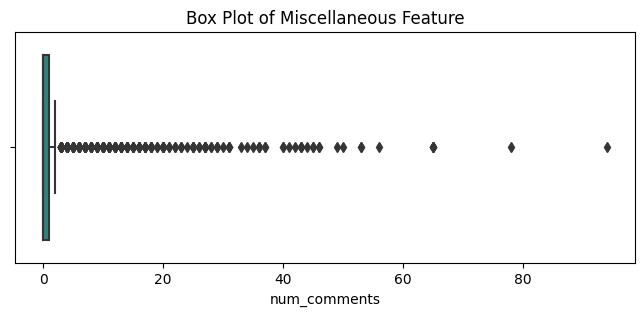

In [46]:
plt.figure(figsize=(8, 3))
sns.boxplot(data = df_combined, x = 'num_comments', palette = 'viridis')
plt.title("Box Plot of Miscellaneous Feature");

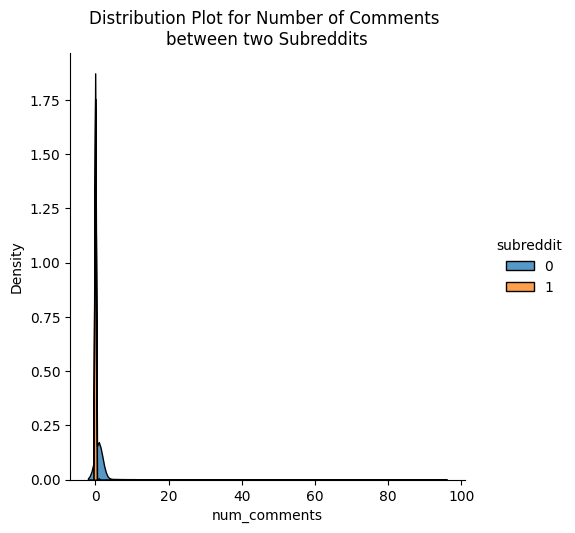

In [47]:
sns.displot(x='num_comments', data=df_combined, hue='subreddit', kind="kde", multiple="stack")
plt.title('Distribution Plot for Number of Comments \nbetween two Subreddits');

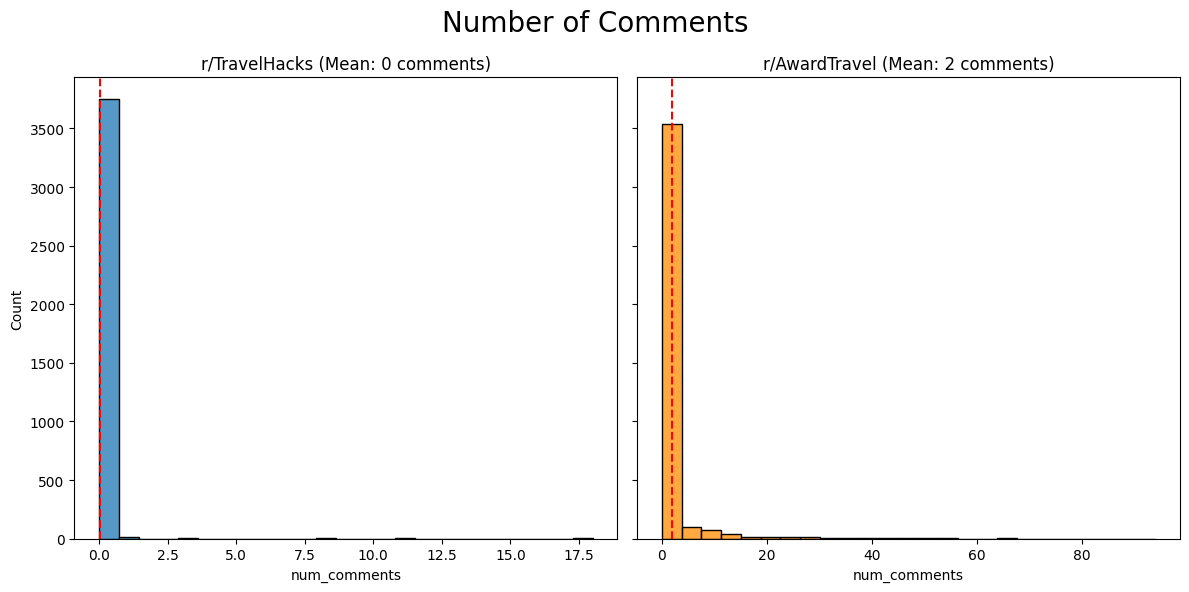

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax = ax.ravel()
mean_1 = travelhacks['num_comments'].mean()
g1 = sns.histplot(data=travelhacks, x='num_comments', ax = ax[0], bins=25)
g1.set_title(f'r/TravelHacks (Mean: {round(mean_1)} comments)')
ax[0].axvline(mean_1, ls='--', color='red')
mean_2 = awardtravel['num_comments'].mean()
g2 = sns.histplot(data=awardtravel, x='num_comments', ax = ax[1], bins=25, color='darkorange')
g2.set_title(f'r/AwardTravel (Mean: {round(mean_2)} comments)')
ax[1].axvline(mean_2, ls='--', color='red')
plt.suptitle('Number of Comments', fontsize=20)
plt.tight_layout()

In [48]:
# drop columns that are not needed for analysis
df_combined.drop(columns = ['utc_datetime_str', 'selftext'], inplace = True)

In [49]:
df_combined.shape

(7620, 5)

In [50]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620 entries, 0 to 7619
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     7620 non-null   int64 
 1   title         7620 non-null   object
 2   author        7620 non-null   object
 3   num_comments  7620 non-null   int64 
 4   text          7620 non-null   object
dtypes: int64(2), object(3)
memory usage: 297.8+ KB


In [51]:
# Save to csv
df_combined.to_csv("../data/df_combined.csv", index=False)

In [52]:
df_combined = pd.read_csv('../data/df_combined.csv')

In [77]:
def subplot_histograms(col, title):
    fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
    ax = ax.ravel()
    
    # Plot first df   
    g1 = sns.histplot(data=travelhacks, x=travelhacks[col].str.len(), ax = ax[0], bins=25)
    mean_1 = travelhacks[col].str.len().mean()
    ax[0].axvline(mean_1, ls='--', color='red')
    g1.set_title(f'r/TravelHacks (Mean: {round(mean_1)} words)')
    g1.set_xlabel(f'Length of {col.capitalize()}')
    
    # Plot second df
    g2 = sns.histplot(data=awardtravel, x=awardtravel[col].str.len(), ax = ax[1], bins=25, color='darkorange')
    mean_2 = awardtravel[col].str.len().mean()
    ax[1].axvline(mean_2, ls='--', color='red')
    g2.set_title(f'r/AwardTravel (Mean: {round(mean_2)} words)')
    g2.set_xlabel(f'Length of {col.capitalize()}')
    plt.suptitle(title, fontsize=16);

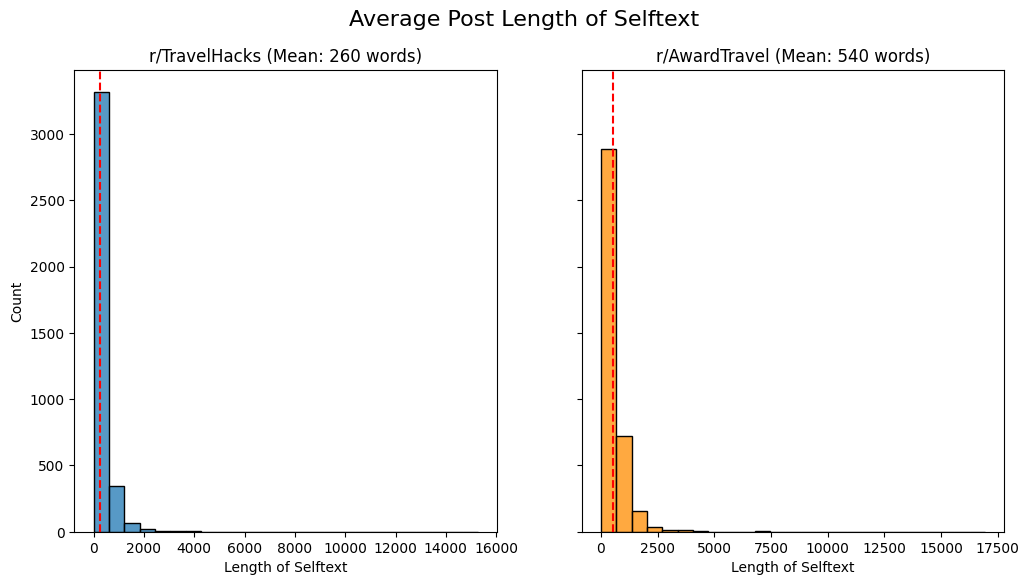

In [78]:
subplot_histograms('selftext', 'Average Post Length of Selftext')

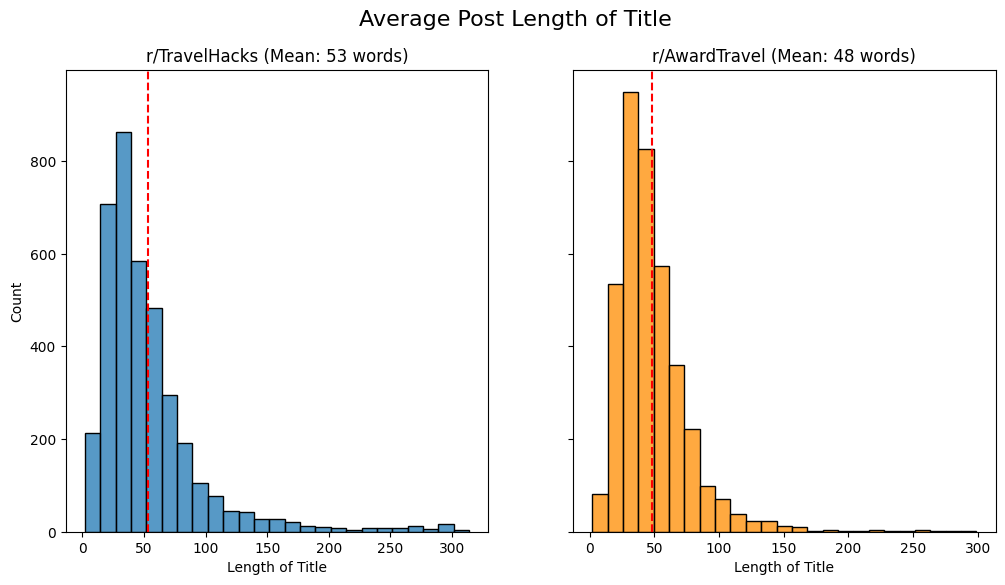

In [79]:
subplot_histograms('title', 'Average Post Length of Title')

#### On average, r/AwardTravel has much longer length of selftext tahn r/TravelHacks

### Text preprocessing

In [53]:
# credit https://stackabuse.com/removing-stop-words-from-strings-in-python/
sp = spacy.load('en_core_web_sm')

stopwords_sp = sp.Defaults.stop_words
#stopwords_sp.remove('not')
print(stopwords_sp)


{'hers', "'d", 'less', 'until', 'is', 'still', 'once', 'it', 'seemed', 'across', 'itself', 'ourselves', 'however', 'those', "'ll", 'should', 'afterwards', 'whenever', 'yourselves', 'whole', 'for', 'amongst', 'much', 'also', 'him', 'some', 'has', 'while', 'third', 'using', 'very', 'go', 'whereafter', 'otherwise', 'into', 'four', 'must', 'give', 'whereupon', 'ours', 'among', 'eleven', 'made', 'to', 'throughout', 'whose', 'even', 'somehow', 'beyond', 'he', 'themselves', 'one', 'them', 'something', 'who', 'again', 'becomes', 'whereas', 'fifteen', "n't", 'anywhere', 'n’t', 'in', 'often', 'whom', 'not', 'moreover', 'upon', 'twenty', 'another', 'both', 'you', 'through', 'quite', 'two', 'up', 'than', 'own', 'have', "'ve", 'keep', 'thereby', 'how', 'out', "'m", 'amount', 'show', 'sometime', 'thru', 'wherever', 'nine', 'forty', 'take', 'whether', 'at', 'am', 'whence', 'three', 'each', 'just', 'a', 'off', 'really', '‘ll', 'becoming', 'doing', 'together', 'that', '’m', 'but', 'everything', 'front'

In [54]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize

In [55]:
from nltk.stem import WordNetLemmatizer

In [56]:
stopwords = set(stopwords.words('english'))
#stopwords.remove('not')

In [57]:
print(stopwords)

{'hers', 'after', 'of', 'can', 'then', 'his', 'up', 'than', 'there', 'own', 'haven', "wasn't", 'have', 're', 'isn', 'mustn', 've', "aren't", 'being', 'how', 'd', "mustn't", 'until', 'out', 'ain', 'is', 'her', 'does', 'once', 'it', 'from', 'which', 'itself', 'ourselves', 'those', "don't", 'their', 'weren', "didn't", 'with', 'should', 'do', 'more', 'hasn', 'now', 'will', "you're", "couldn't", 'aren', "you'll", "needn't", 'against', 'other', 'at', 'am', 'so', "shouldn't", 'our', 'be', 'under', 'yourselves', "isn't", 'for', "that'll", 'each', 'himself', 'shan', 'y', 'where', 'why', 'wasn', 'herself', 'a', 'off', 'just', 'll', 'about', 'him', 'some', 'has', 'while', 'won', 'such', 'very', "it's", "you've", 's', 'doing', "you'd", 'its', 'couldn', 'these', 'that', 'into', 'as', 'don', 'your', 'same', 'but', 't', "hadn't", 'before', "mightn't", 'ma', 'was', 'the', 'myself', 'and', 'ours', 'below', 'only', 'hadn', 'to', 'wouldn', 'mightn', "won't", 'had', 'this', 'all', 'because', 'doesn', 'he'

In [58]:
# credit: https://www.w3schools.com/python/gloss_python_join_sets.asp
all_stopwords = stopwords_sp.union(stopwords)

In [59]:
print(all_stopwords)

{'hers', "'d", 'of', 'can', 'already', 'less', 'there', 'haven', 'around', 'n‘t', 'being', "mustn't", 'won', 'former', 'until', 'ain', 'is', 'still', 'beside', 'her', 'once', 'ca', 'it', 'does', 'from', 'seemed', 'across', 'itself', 'ourselves', 'however', 'those', "don't", 'their', 'alone', 'weren', "'ll", 'should', 'hasn', 'afterwards', 'more', 'many', 'noone', 'now', 'several', 'next', 'will', "couldn't", "you'll", 'whenever', "needn't", 'so', 'our', 'rather', 'be', 'yourselves', 'whole', 'for', 'amongst', 'within', 'much', 'shan', 'wasn', 'also', 'll', 'almost', '’re', 'him', 'some', 'has', 'while', "'re", 'third', 'using', 'herein', 'last', 'very', 'such', 'full', 'besides', "you've", 'go', 'either', 'since', 'hereupon', "you'd", 'whereafter', 'otherwise', 'always', 'its', 'everywhere', 'into', 'side', 'four', '‘m', 'don', 'nobody', 'became', '‘d', 't', 'before', 'must', 'name', 'give', 'wherein', 'namely', 'and', 'someone', 'whereupon', 'ours', 'among', 'eleven', 'made', 'whereby

In [60]:
# additional keywords for removal
#add_stopwords = ['www', '.com', 'com', 'http', 'https']
#add_stopwords = set(add_stopwords)
#type(add_stopwords)

In [61]:
#more_stopwords = all_stopwords.union(add_stopwords)
#print(more_stopwords)

#### Function for text cleaning

In [62]:
df_combined = pd.read_csv('../data/df_combined.csv')

In [63]:
# adopted from class
# credit: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
# credit: https://www.geeksforgeeks.org/python-removing-newline-character-from-string/
# credit: https://stackoverflow.com/questions/43356467/removing-special-characters-and-symbols-from-a-string-in-python
# credit: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
# credit: https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb
# credit: https://pypi.org/project/redditcleaner/

# initialize list of newline characters
#newline_characters = ['\\ng', 'i\ns', 'b\nest', '\n\n', '\n', '\t', '\\']

def preprocess(text):

    # use redditcleaner to remove special characters used in the raw text at reddit
    # such as &amp;#x200B, newline_characters (\n\n)
    text = redditcleaner.clean(text)  
    
    # using contractions.fix to expand the shortened words
    text = contractions.fix(text)
        
    # convert to lowercase
    text = text.lower()
    
    # initiate BeautifulSopu to strip HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ") # Get all the text other than html tags.
    
    # remove links starts with https and/or end with .com
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\ *\.com', '', text)
    
    # remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)    
    
    # remove newlines tabs
    #for characters in newline_characters:
    #    text = text.replace(characters, ' ') 
    
    # remove extra white spaces
    text = re.sub('\s+', ' ', text).strip()  
  
    # split into individual words
    words = text.split()
        
    # remove stop words
    meaningful_words = []
    for w in words:
        if w not in all_stopwords:
            meaningful_words.append(w)
              
    # lemmatizer the words
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]    
    
    return ' '.join(tokens_lem)

In [64]:
df_combined['text_cleaned'] = df_combined.apply(lambda x: preprocess(x['text']), axis=1)
df_combined.head()

C:\Users\skyne\AppData\Local\Temp\ipykernel_6180\2602187967.py:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\skyne\AppData\Local\Temp\ipykernel_6180\2602187967.py:25: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,subreddit,title,author,num_comments,text,text_cleaned
0,1,Winging Costa rica,lucylovesugly1,0,Winging Costa rica Has anyone booked a flight ...,winging costa rica booked flight costa rica bo...
1,1,"I'm planning a backpacking trip to Romania, an...",wbtr42,0,"I'm planning a backpacking trip to Romania, an...",planning backpacking trip romania tip hey frie...
2,1,Are there any budget friendly ways to get a ta...,bak1n,0,Are there any budget friendly ways to get a ta...,budget friendly way taste arctic hey planning ...
3,1,Niagara Falls NY,Proud-Assumption-353,0,Niagara Falls NY,niagara fall ny
4,1,Nice &gt; Rome flights/airlines,efisk1990,0,Nice &gt; Rome flights/airlines I’m heading to...,nice rome flight airline heading europe work j...


In [65]:
# before text cleaning
df_combined['text'][0:5].unique()

array(['Winging Costa rica Has anyone booked a flight to Costa Rica without a booking and tried to get accommodation from the source? I’ve heard that it can cut the cost substantially cutting out the middle man and I’m wondering if anyone has any experience doing that?',
       "I'm planning a backpacking trip to Romania, any tips? Hey, me and my friend are planning to go on a two-week backpacking trip to romania this summer. Any tips what we should not miss or what to be cautious about?",
       'Are there any budget friendly ways to get a taste for the Arctic? Hey all. Planning on a visit to Chile and Argentina later this year. I was very interested in visiting Antarctica as well but after seeing the $15-20K price tags I nope’d out of that. Patagonia is beautiful but wanting to seek something a bit more frigid. (I’m from the midwestern US, so I’d love to see if something colder exists). \n\nAnybody know of any ferries or cruises perhaps that make a visit through Drake Passage from th

In [66]:
# after text cleaning
df_combined['text_cleaned'][0:5].unique()

array(['winging costa rica booked flight costa rica booking tried accommodation source heard cut cost substantially cutting middle man wondering experience',
       'planning backpacking trip romania tip hey friend planning week backpacking trip romania summer tip miss cautious',
       'budget friendly way taste arctic hey planning visit chile argentina later year interested visiting antarctica seeing k price tag nope patagonia beautiful wanting seek bit frigid midwestern love colder exists anybody know ferry cruise visit drake passage chilean patagonia break bank know expensive destination willing review option thanks',
       'niagara fall ny',
       'nice rome flight airline heading europe work june want extend trip pleasure second time traveling europe north america clueless european airline nice france work want rome flight wizz easyjet way seeing low american absolutely shocked short flight low paid flight year second airline horrible fly catch choosing spirit airline france go

In [67]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620 entries, 0 to 7619
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     7620 non-null   int64 
 1   title         7620 non-null   object
 2   author        7620 non-null   object
 3   num_comments  7620 non-null   int64 
 4   text          7620 non-null   object
 5   text_cleaned  7620 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.3+ KB


In [68]:
# Save to csv
df_combined.to_csv("../data/df_cleaned.csv", index=False)

In [84]:
# adopted from class
def plot_top_words(df, col, n, ngram, title, palette = 'rocket'):
    def top_n_words(corpus, n=n, k=ngram):     
        cvec = CountVectorizer(ngram_range=(k,k), stop_words='english').fit(corpus)     
        words = cvec.transform(corpus)     
        sum_words = words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idex]) for word, idex in cvec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    word_df = pd.DataFrame(data=top_n_words(df[col], n), columns=['word','freq'])
    plt.figure(figsize=(10,6))
    sns.barplot(data=word_df, y='word', x='freq', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=18)

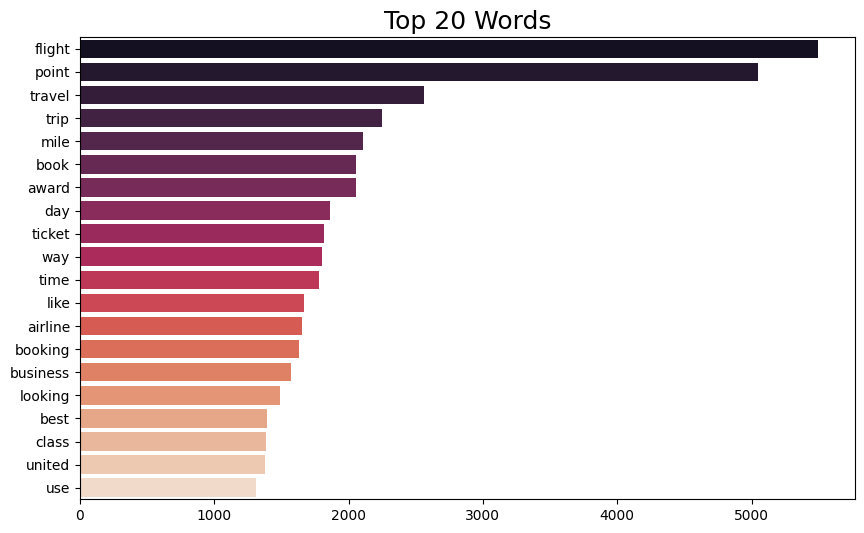

In [86]:
plot_top_words(df_combined,'text_cleaned', 20, 1, 'Top 20 Words')

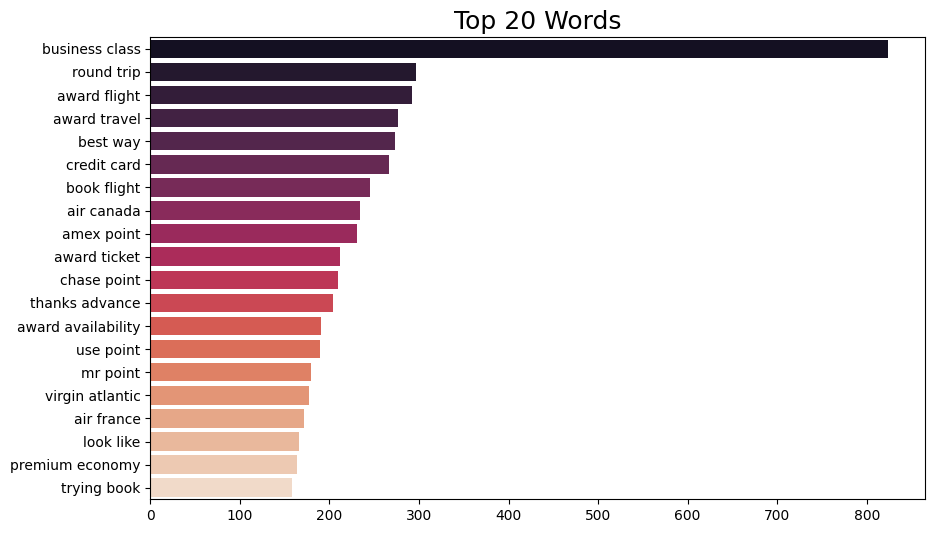

In [87]:
plot_top_words(df_combined,'text_cleaned', 20, 2, 'Top 20 Words')

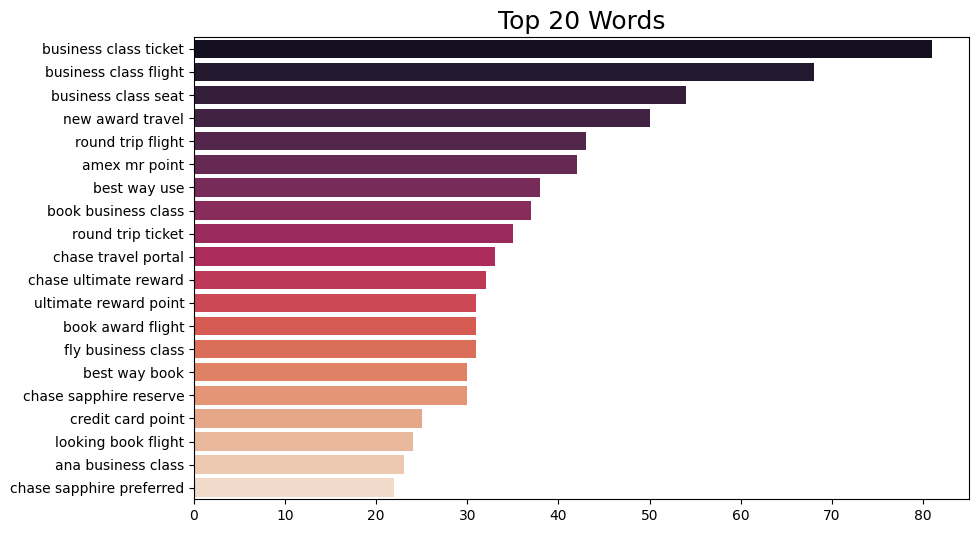

In [88]:
plot_top_words(df_combined,'text_cleaned', 20, 3, 'Top 20 Words')

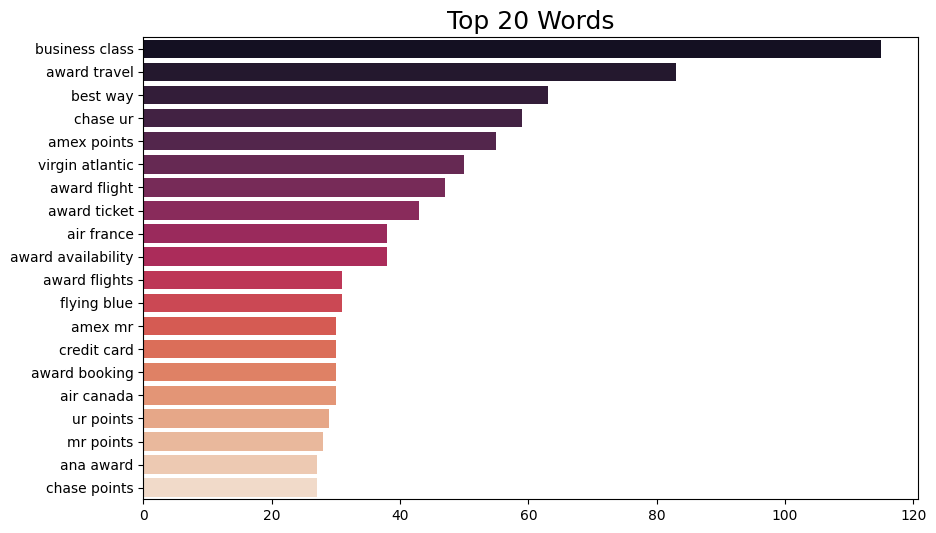

In [98]:
plot_top_words(awardtravel,'title', 20, 2, 'Top 20 Words')